### 네이버 검색 결과 크롤링 - 수원 맛집

In [24]:
import pandas as pd
import requests
from urllib.parse import quote
from bs4 import BeautifulSoup

- requests.get()으로 데이터를 크롤링하는 경우

In [25]:
url = 'https://search.naver.com/search.naver?where=view&sm=tab_jum&query=' + quote('수원맛집')
res = requests.get(url, 'html.parser')
soup = BeautifulSoup(res.text)

<!DOCTYPE html>
<html lang="ko"> <head> <meta charset="utf-8"/> <meta content="always" name="referrer"/> <meta content="telephone=no,address=no,email=no" name="format-detection"/> <meta content="width=device-width,initial-scale=1.0,maximum-scale=2.0" name="viewport"/> <meta content="수원맛집 : 네이버 VIEW검색" property="og:title"/> <meta content="https://ssl.pstatic.net/sstatic/search/common/og_v3.png" property="og:image"/> <meta content="'수원맛집'의 네이버 VIEW검색 결과입니다." property="og:description"/> <meta content="'수원맛집'의 네이버 VIEW검색 결과입니다." lang="ko" name="description"/> <title>수원맛집 : 네이버 VIEW검색</title> <link href="https://ssl.pstatic.net/sstatic/search/favicon/favicon_191118_pc.ico" rel="shortcut icon"/> <link href="https://ssl.pstatic.net/sstatic/search/opensearch-description.https.xml" rel="search" title="Naver" type="application/opensearchdescription+xml"/><link href="https://ssl.pstatic.net/sstatic/search/pc/css/search1_230420.css" rel="stylesheet" type="text/css"/> <link href="https://ssl.pstati
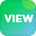

In [26]:
soup

In [27]:
lis = soup.select('.bx._svp_item')
len(lis)

30

- Selenium을 이용해서 데이터 크롤링

In [28]:
from selenium import webdriver
import warnings
warnings.filterwarnings('ignore')

driver = webdriver.Chrome('C:/Users/YONSAI/Desktop/chromedriver_win32/chromedriver.exe')
driver.get(url)

In [29]:
# View 페이지를 아래로 내려서 많은 데이터를 확보
import time
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

body = driver.find_element(By.TAG_NAME, 'body')
for i in range(30):
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)

In [30]:
soup = BeautifulSoup(driver.page_source)
lis = soup.select('.bx._svp_item')
len(lis)

110

In [31]:
driver.close()

- 날짜, 제목, 내용 크롤링

In [32]:
# 날짜
li = lis[0]
date = li.select_one('.sub_time.sub_txt').get_text().strip()
date

'2023.04.05.'

In [33]:
# 제목
title = li.select_one('.api_txt_lines.total_tit._cross_trigger').get_text().strip()
title

'일품이던 수원맛집베스트10'

In [34]:
# 내용
content = li.select_one('.api_txt_lines.dsc_txt').get_text().strip()
content[:200]

'하러 수원맛집베스트10에 속한다는 갈비집을 다녀왔어요. 동네 주민들 뿐만 아니라 멀리서도 많은 사람들이 찾아가는 곳이라는데 소문대로 고퀄리티의 식사를 즐길 수 있던 곳이었어요. 고반가든 서수원점 주소 : 경기...'

- 날짜 처리

In [35]:
from datetime import datetime, timedelta

today = datetime.now()
today

datetime.datetime(2023, 4, 25, 12, 17, 44, 982553)

In [36]:
# 어제
date = today - timedelta(1)
f'{date.year}.{date.month:02d}.{date.day}'

'2023.4.24'

In [38]:
# 23시간전
date = today - timedelta(hours=23)
f'{date.year}.{date.month:02d}.{date.day}'

'2023.4.24'

In [39]:
# 45분전
date = today -timedelta(minutes=45)
date.strftime('%Y.%m.%d')

'2023.04.25'

In [40]:
def convert_date(s):
    if len(s) == 11:        # '2023.04.25.'
        return s[:-1]
    
    today = datetime.now()
    if '어제' in s:
        date = today - timedelta(1)
    elif '일' in s:
        date = today - timedelta(int(s[0]))
    elif '시간' in s:
        date = today - timedelta(hours=int(s[:-4]))
    elif '분' in s:
        date = today - timedelta(minutes=int(s[:-3]))
    
    return date.strftime('%Y.%m.%d')

- 데이터 프레임 만들기

In [41]:
lines = []
for li in lis:
    date = li.select_one('.sub_time.sub_txt').get_text().strip()
    date = convert_date(date)
    title = li.select_one('.api_txt_lines.total_tit._cross_trigger').get_text().strip()
    content = li.select_one('.api_txt_lines.dsc_txt').get_text().strip()
    lines.append({'date':date, 'title':title, 'content':content})
lines

[{'date': '2023.04.05',
  'title': '일품이던 수원맛집베스트10',
  'content': '하러 수원맛집베스트10에 속한다는 갈비집을 다녀왔어요. 동네 주민들 뿐만 아니라 멀리서도 많은 사람들이 찾아가는 곳이라는데 소문대로 고퀄리티의 식사를 즐길 수 있던 곳이었어요. 고반가든 서수원점 주소 : 경기...'},
 {'date': '2022.05.02',
  'title': '럭셔리한 수원 맛집',
  'content': '후식까지 훌륭했던 수원 맛집이라 조만간 가족들과도 또 와보려고 해요. 2. 행궁빙수 음식 : 인절미 5,000원 매장 : 경기 수원시 팔달구 정조로 905번길 19 송아당 행궁빙수 문의 : 031-242-8685 운영시간 : 매일 11:00 - 21:00...'},
 {'date': '2023.04.23',
  'title': '수원 맛집 영통역 고기집 육풍 영통프라임점 맛있어',
  'content': '아이와 주말에 정말 맛있게 점심 먹었네요 ❤ 수원 맛집 육풍 영통프라임점 ✔ 경기 수원시 영통구 매영로393번길 31 1층 ✔ 평일 16:00 - 01:00 / 주말 오후 12:30 - 01:00 ☎ 0507-1489-0505 / 주차 가능'},
 {'date': '2023.04.24',
  'title': '수원 맛집 신라갈비 한우생갈비의 품격',
  'content': '유명 #수원맛집 후기입니다. 이날 다녀온 신라갈비는 가보정과 본수원갈비와 함께 전국적인 명성을 가지고... 그럼 좋은 하루되세요. 끝. #신라갈비 #정사장부부맛집투어 한 줄 평 : 30분만에... 20만원이 뱃속으로...'},
 {'date': '2022.05.20',
  'title': '호기롭던 수원 맛집',
  'content': '달짝지근한 아이스크림과 바디감 높은 아메리카노로 마무리까지 확실했던 수원 맛집이었어요. 2. 평지담 음식 : 제주말차라떼 6,500원 매장 : 경기 수원시 팔달구 정조로 847 3층 문의 : 070-8802-8

In [43]:
df = pd.DataFrame(lines)
df.tail()

,date,title,content
105,2023.04.14,수원 맛집 가성비와 분위기 좋은 미도인,서울에서 핫한 미도인의 맛을 수원에서도 느낄 수 있어서 좋았어요 ! 경기 수원시 팔...
106,2023.04.13,"수원 맛집 소담화로 소갈비살 추천, 주차 정보",고기도 진짜 맛도리에요 >_< 가족외식 장소로도 회식장소로도 추천드려욤 #수원소고기...
107,2023.04.24,수원 맛집 호매실 돈가스 맛집 이백장돈가스 수원호매실점,#이백장돈가스 #이백장돈가스수원호매실점 #호매실돈가스 맛집 #호매실돈까스맛집 #수원...
108,2023.04.23,(수원맛집) 영양 가득 보양식 백세삼계탕,곳으로 수원 나가는 초입인 이목동에 위치해 잇어 접근성이 참 좋기도 합니다 지인이 ...
109,2023.04.16,재방문 200% 최애닭강정 <아들닭강정> 수원 맛집 내돈내산 주차가능,다음에도 맷집이네 놀러오세요~ #수원닭강정맛집 #수원치킨맛집 #수원통닭맛집리스트 #...
